In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,4.27)})
import matplotlib.pyplot as plt

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Context

In [3]:
dtype = {"Survived" : "str" , "Pclass" : "str", "PassengerId" : "str"}
df = pd.read_csv('train.csv', dtype=dtype)

__Описание:__
 - Survived - Выжил или нет: 0 = Нет, 1 = Да
 - Pclass - Класс билета: 	
 	- 1st = Upper
	- 2nd = Middle
	- 3rd = Lower
 - Name	- Имя пассажира
 - Sex - пол: male female
 - Age - Возраст в годах
 - SibSp - количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника
 - Parch - количество родителей, детей (в том числе приемных) на борту титаника;
 - Ticket - Номер билета
 - Fare	- Плата за проезд
 - Cabin - Номер каюты
 - Embarked - Порт посадки на корабль: C — Шербур; Q — Квинстаун; S — Саутгемптон

In [43]:
# сделаем маппинг на порт посадки
emarked = {'C': 'Шербур', 'Q' : 'Квинстаун', 'S' : 'Саутгемптон'}
df['Embarked'] = df['Embarked'].map(emarked)

In [4]:
# введем новое поле: был ли человек в родсвенных связях с кем-то на борту
df['Single?'] = df.apply(lambda x:  1 if (x['SibSp'] + x['Parch'])  == 0 else 0 , axis= 1)

# Data quality assessment

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  object 
 1   Survived     100000 non-null  object 
 2   Pclass       100000 non-null  object 
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
 12  Single?      100000 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 9.9+ MB


In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Single?
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,0
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S,1
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,1
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1


## Проверка пропущенных значений

In [7]:
# найдем долю пропусков в датафрейме
col = 'misiing_val_ratio'
(pd.DataFrame(100*df.isna().sum()/df.shape[0], columns=[col])
    .sort_values(by = col, ascending= False)
    .head(5))

,misiing_val_ratio
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134


Text(0.5, 1.0, 'Визуализация пропусков')

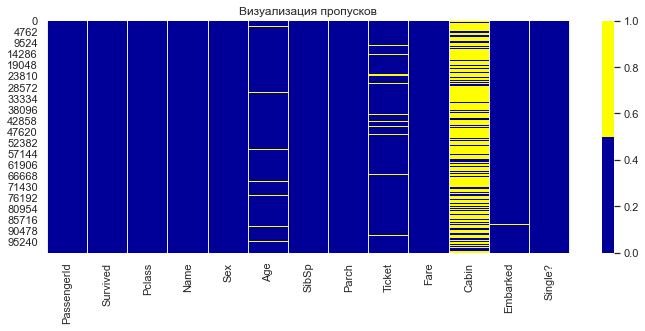

In [8]:
# визуализируем пропуски
# желтый - пропущенные данные, синий - не пропущенные
cols = df.columns 
colours = ['#000099', '#ffff00'] 
ax = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
ax.set_title('Визуализация пропусков')

# Data exploration

## Исследовние выживаемости

In [9]:
def agg_func(aggregate_column:str, new_name: dict)->pd.DataFrame:
    '''
    Функция, которая агрегирует в нужный формат данныx
    Аргументы:
    ---------
    - aggregate_column - клонка для агрегирования
    -  new_name - словарь с новыми именами для переименовывания
    '''
    return (df.groupby(aggregate_column)
            .agg({'PassengerId': lambda x: 100 * len(x) / df.shape[0]})
            .reset_index()
            .rename(columns = new_name)
            )  

In [10]:
def plot_two_separate_bar(xs: pd.Series,  ys: pd.Series)-> None: 
    '''
    Функция, которая строит визуализациию в виде столбч. диаграммы с подписью 
     Аргументы:
    ---------
    - xs - данные по оси OX
    - ys - данные по оси OY
    '''
    plt.bar(xs,ys,color = list('rgbkymc'))
    for x,y in zip(xs,ys, ):
        label = f"{y:.2f} % "
        plt.annotate(label, 
                    (x,y), 
                    textcoords = "offset points", 
                    xytext = (0,10), 
                    ha ='center')

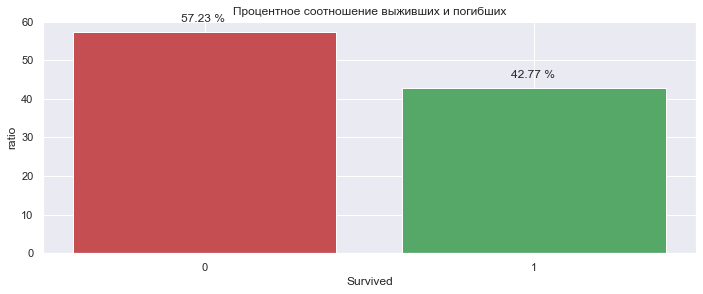

In [11]:
# рассмотрим количево выживших и погибших в результате крушения Титаника

data = agg_func(aggregate_column = 'Survived', new_name = {'PassengerId' : 'ratio'})
plot_two_separate_bar(xs = data['Survived'],  ys = data['ratio'] )
plt.title('Процентное соотношение выживших и погибших')
plt.xlabel('Survived')
plt.ylabel('ratio')
plt.show()

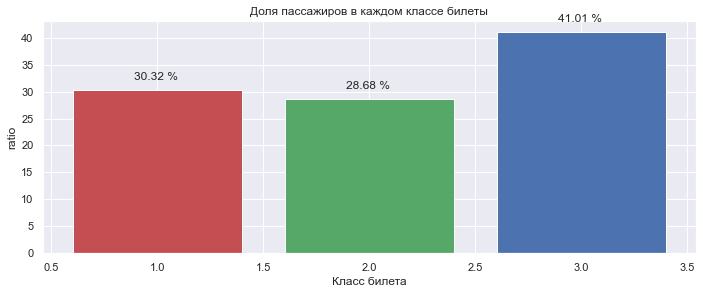

In [37]:
data = agg_func(aggregate_column = 'Pclass', new_name = {'index' : "Pclass", 'PassengerId': 'ratio'})
plot_two_separate_bar(xs = data['Pclass'],  ys = data['ratio'] )
plt.title('Доля пассажиров в каждом классе билеты')
plt.xlabel('Класс билета')
plt.ylabel('ratio')
plt.show()

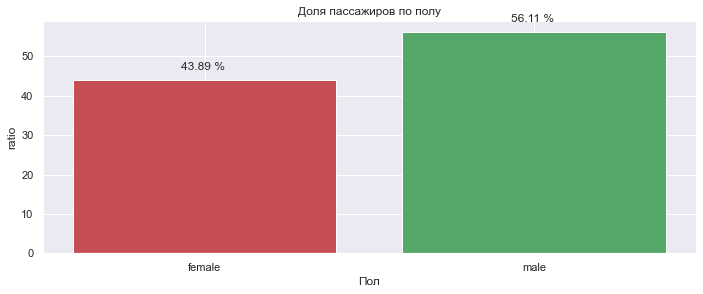

In [46]:
data = agg_func(aggregate_column = 'Sex', new_name = {'index' : "Sex", 'PassengerId': 'ratio'})
plot_two_separate_bar(xs = data['Sex'],  ys = data['ratio'] )
plt.title('Доля пассажиров по полу')
plt.xlabel('Пол')
plt.ylabel('ratio')
plt.show()

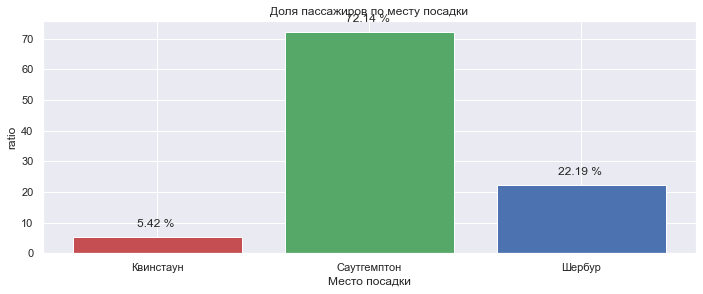

In [47]:
data = agg_func(aggregate_column = 'Embarked', new_name = {'index' : "Embarked", 'PassengerId': 'ratio'})
plot_two_separate_bar(xs = data['Embarked'],  ys = data['ratio'] )
plt.title('Доля пассажиров по месту посадки')
plt.xlabel('Место посадки')
plt.ylabel('ratio')
plt.show()

In [13]:
def grouping_data(col: str) -> pd.DataFrame:
    '''
    Группировка датафрейма в нужном формате для визуализации
    '''
    inner_df = (df.pivot_table(index = [col, 'Survived'], values='PassengerId' , aggfunc='count')
                    .reset_index()
                    .rename(columns={'PassengerId' : 'cnt'}))
    inner_df['ratio_by_total'] = 100 * inner_df['cnt'] / sum(inner_df['cnt'])
    inner_df['ratio_by_fraction'] = 100*inner_df['cnt'] / inner_df.groupby([col])['cnt'].transform(sum) 
    return inner_df

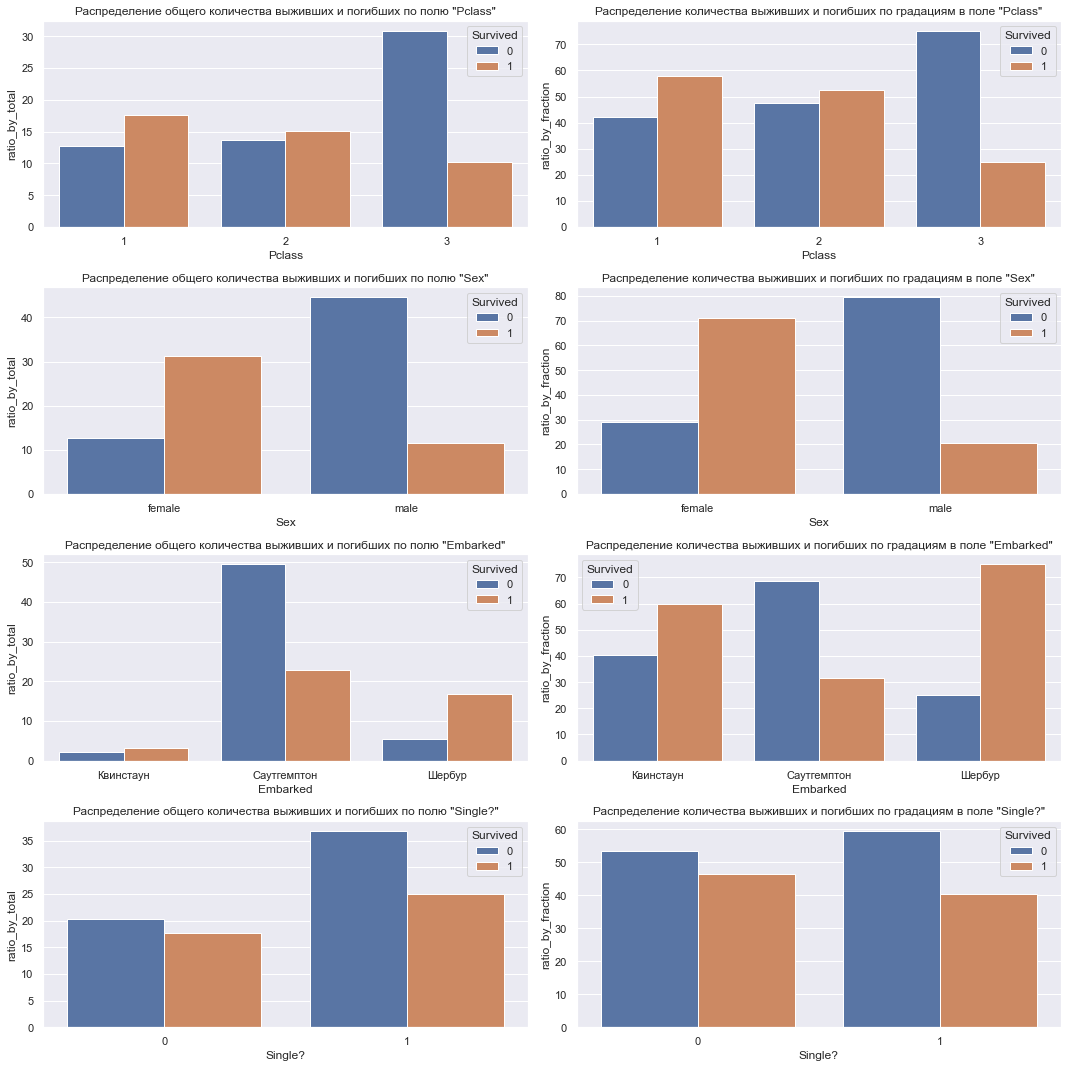

In [50]:
# рассмотрим распредление погибших и выживших в разнх разрезах
#  (взависимости от класса, пола, наличия систер, родителей, порта посадки) 
cols = ["Pclass", "Sex",  "Embarked", 'Single?']
n_rows = len(cols)
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 15), squeeze= False)
for i, col in enumerate(cols):
    for j in range(n_cols):
        if j == 0:
            grouping_col = 'ratio_by_total'
            title = f'Распределение общего количества выживших и погибших по полю "{cols[i]}"'
        else:
            grouping_col = 'ratio_by_fraction'
            title = f'Распределение количества выживших и погибших по градациям в поле "{cols[i]}"'
        ax = axes[i][j]
        ax = sns.barplot(data = grouping_data(col), x = col, hue = 'Survived', y = grouping_col, ax=ax)
        ax.set_title(title) 
plt.tight_layout()


## Исследование стоимости билетов

<AxesSubplot:xlabel='Fare', ylabel='Pclass'>

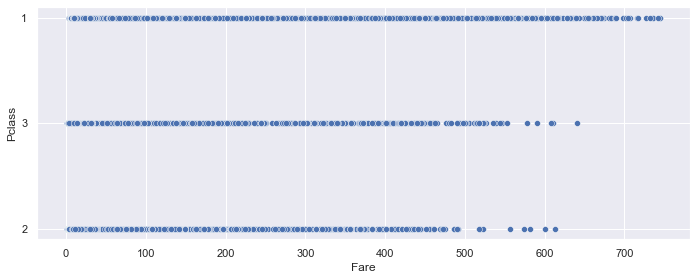

In [16]:
# скатерплот для стоимости билета взависимости от класса 
sns.scatterplot(df["Fare"],  df["Pclass"])

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

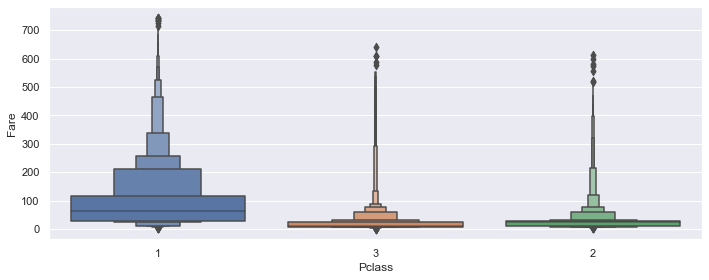

In [17]:
sns.boxenplot(y = df["Fare"], x = df["Pclass"])

# Исследование возраста

<AxesSubplot:xlabel='Age', ylabel='Count'>

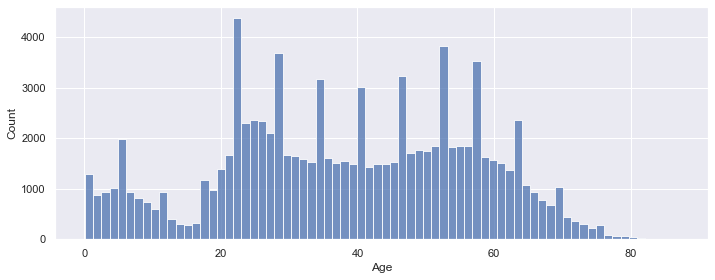

In [18]:
# Looking at distribution of the age
sns.histplot(df["Age"].dropna(), kde= False)

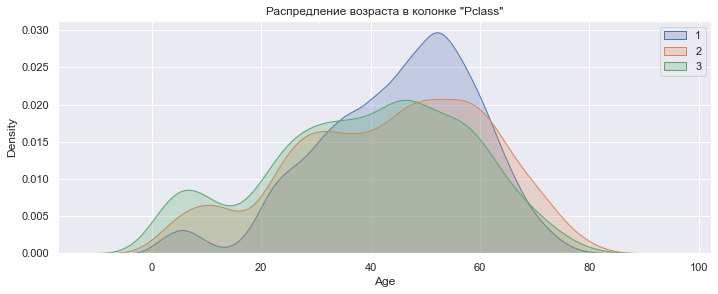

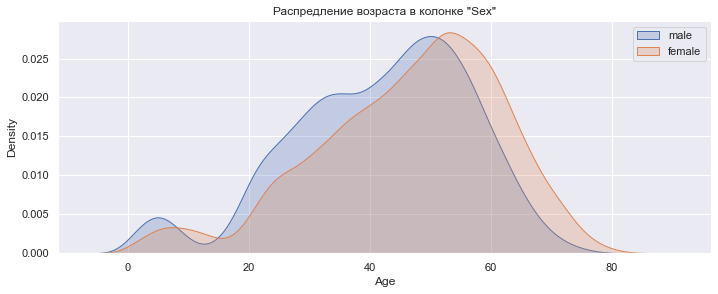

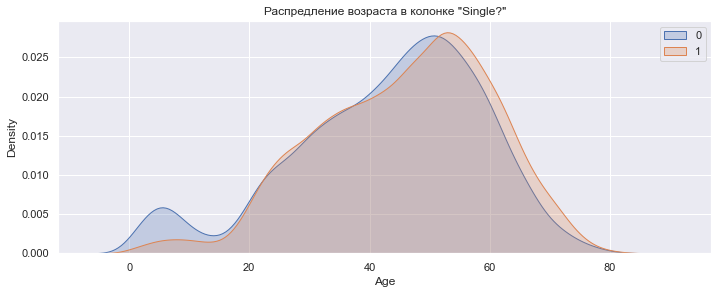

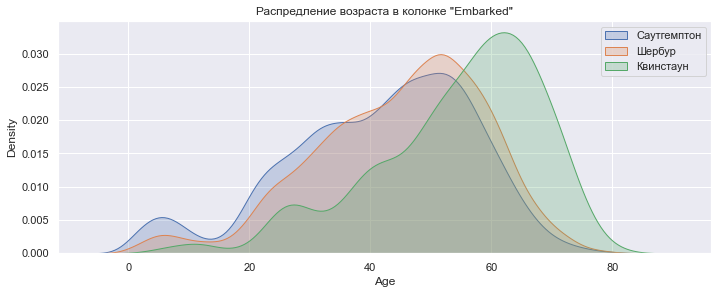

In [51]:
for i in ['Pclass', 'Sex', 'Single?','Embarked']:
        unique = df.dropna()[i].unique()
        for j in unique:
                data = df.dropna()[df.dropna()[i] == j]['Age']
                sns.kdeplot(data = data, label=j, shade=True)
                plt.legend()
                plt.title(f'Распредление возраста в колонке "{i}"')
        plt.show()

In [30]:
df.Survived = df.Survived.astype('int')
df.Pclass = df.Pclass.astype('int')

In [53]:
col_for_corrilation_plot = ['Survived', 'Pclass',  'Age', 'Fare']

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

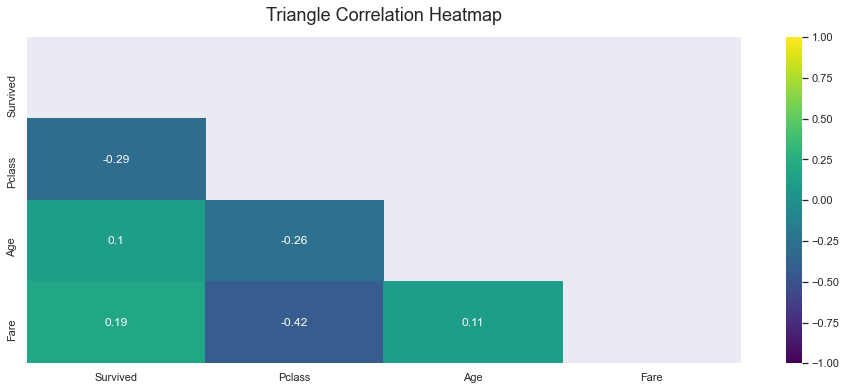

In [54]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df[col_for_corrilation_plot].corr(), dtype=np.bool))
heatmap = sns.heatmap(df[col_for_corrilation_plot].dropna().corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='viridis')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

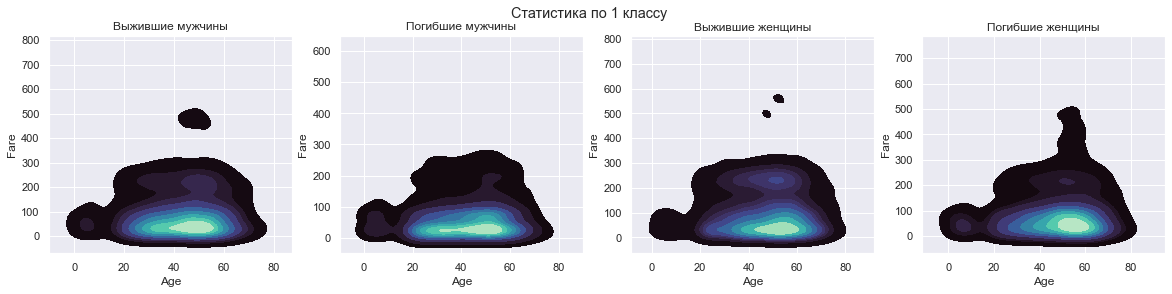

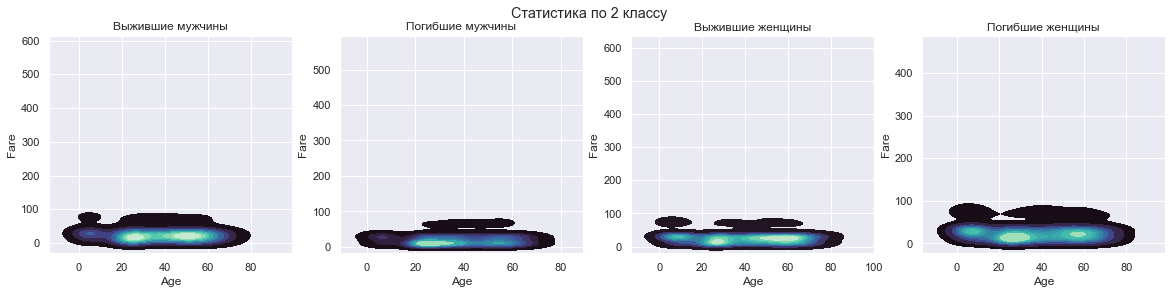

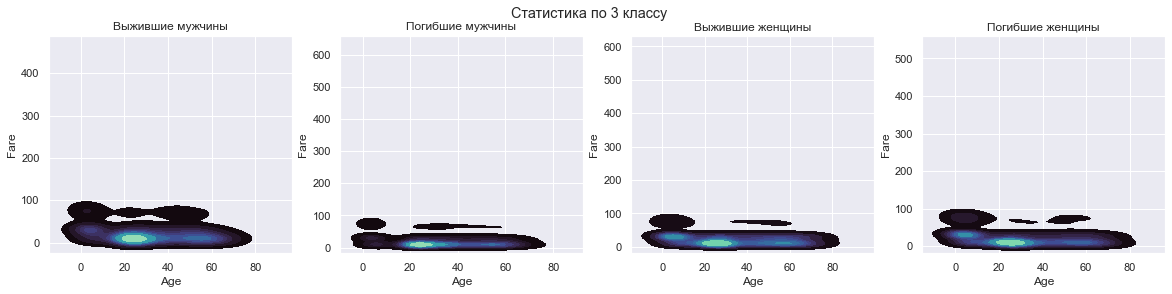

In [36]:
for class_ in range(1, 4):
    f , axes = plt.subplots(1, 4, figsize = (20, 4))
    f.suptitle(f'Статистика по {class_} классу')
    for alive in range(2):
        for sex in df.Sex.unique():
            
            if alive == 1 and sex == 'male':
                id = 0
                title = 'Выжившие мужчины'
            elif alive == 0 and sex == 'male':
                id = 1
                title = 'Погибшие мужчины'
            elif alive == 1 and sex == 'female':
                id = 2
                title = 'Выжившие женщины'
            else:
                id = 3
                title = 'Погибшие женщины'

            sns.kdeplot(
                        data = (df.query("Pclass == @class_ and Survived == @alive and Sex == @sex")[col_for_corrilation_plot]
                                .dropna()
                                # .head(5*10**4)
                                )
                        , x="Age"
                        , y="Fare"
                        ,fill=True
                        ,cmap="mako"
                        , ax = axes[id]
                    )

            axes[id].set_title(title)

# Summary

- Большая часть людей погибла (57 % )
- Наибольшее кол-во людей были представители 3-го класса (41 %)
- Наибольшее количество погибших (30 %) приходится на пассажиров  3 класса, наименьшее число выживших от общего числа пассажиров (10 %) на борту приходиться также на людей 3-го класса
- Наибольший дисбаланс среди погибших и выживших приходится на 3-й класс (75 на 25), доли погибших и выживших во втором классе примерно равны, среди представителей первого класса выжило - 60%, погибло - примерно 40%
- Доля выживших женщин от общего числа женщин намного больше доли выживших
Мужчин от общего числа мужчин: 70 % против 20%
- Наибольшее число погибших приходится на тех пассажиров,  что сели в порту Саутгемптона
- Большая доля людей, погибших в результате катастрофы не имела родственных отношений с кем-либо на борту
- Возраст большинства пассажиры был от  20 по 60 лет.
- Наиболее дорогие билеты были у людей 1-го класса, однако для второго и для третьего класса имеются выбросы вправо по стоимости билетов
- Наибольшее количество людей в возрасте от 50 до 60 были представителями 1-го класса 
- Вероятность, что случайно встретившийся ребенок на борту был представителем 3-го класса намного выше, чем вероятность, что это был бы ребенок из 1-го класса
- На корабле было больше пожилых мужчин, чем женщин, но маленьких девочек было больше, чем маленьких мальчиков 
- Большинство детей ехало с родителями/родственниками, доля людей не связанные родственными связями среди других возрастов примерны равны
- Наиболее пожилые люди сели в порту Квинстаун, больше всего маленьких детей село в порту Саутгемптона
- В данных нет сильных попарных корреляционных связей между переменными 
- Среди людей 2-го класса погибло больше молодых мужчин (20-40 лет), 
- Люди с дорогими билетами выживали только в том случае, если они были представителями первого класса
